In [1]:
import pandas as pd

import glob

from pathlib import Path
import csv

import os
import requests
import json

from dotenv import load_dotenv
load_dotenv()

True

In [2]:
## Calls and Functions for reading data downloaded from SEC website 
header = "SETTLEMENT DATE|CUSIP|SYMBOL|QUANTITY (FAILS)|DESCRIPTION|PRICE"

path = r'C:\Users\watso\Desktop\TherinFintech\GME_Shenanigans\SEC_Files_CSV' # USE YOUR PATH 
all_files = glob.glob(path + "/*.csv")

GME_CUSIP_number = "36467W109"   
GME_symbol = 'GME'

CUSIP_number = "36467W109"   # Default  
symbol = 'GME'               # Default

# Main function - passing the CUSIP number (most important) and setting the symbol will deliver
#                 FTD data sorted by CUSIP number 
# All other functions here exist to support this 
def return_dataframe(cusip_number,symbol):
    df = read_ftd_data_any_stock(cusip_number,symbol)
    df = fix_dataframe(df)
    return df

# Use return_dataframe as your function to call FTD Data 


def read_ftd_file(csv_path, cusip_number, symbol):
    data = pd.read_csv(
    Path(csv_path),
    index_col=False
    )
    
    data[header] = data[header].str.replace('|',',')
    new_data = data.rename(columns={header:'SETTLEMENT_DATE,CUSIP,SYMBOL,QUANTITY_FAILS,DESCRIPTION,PRICE'})
    Header = "Header"
    new_data = data.rename(columns={header:Header})
    
    new_data = new_data.Header.str.split(",",expand=True)
    new_data = new_data.rename(columns={0:'Date',1:'CUSIP',2:'SYMBOL',3:'QUANTITY_FAILS',4:'DESCRIPTION',5:'PRICE'})
    
    new_data = new_data.set_index("CUSIP")
    new_data = new_data.loc[cusip_number]
    
    new_data = new_data[['Date','QUANTITY_FAILS','PRICE']]
    new_data.rename(columns={'PRICE':symbol},inplace=True)
    new_data.set_index('Date',inplace=True)  
    
    new_data = new_data.reset_index()
    new_data['Date'] = pd.to_datetime(new_data['Date'])
    new_data.set_index('Date',inplace=True)
    new_data = new_data[['QUANTITY_FAILS']]
    new_data.rename(columns={'QUANTITY_FAILS':symbol+'_QUANTITY_FAILS'},inplace=True)
    
    return new_data

def read_ftd_data_any_stock(cusip_number,symbol):
    new_df = pd.DataFrame()
    for filename in all_files:
        if filename == 0:
            new_df = read_ftd_file(csv_path=filename ,cusip_number=cusip_number,symbol=symbol)
        else:
            new_df2 = read_ftd_file(csv_path=filename ,cusip_number=cusip_number,symbol=symbol)
            new_df = concat_df(new_df,new_df2)
            
    return new_df

def fix_dataframe(dataframe):
    # For whatever reason, exporting data to CSV file, then reimporting back in using Pandas
    # solves all issues when it comes to reading the data in the column 
    dataframe.to_csv('FilesTemp/temp.csv')
    dataframe = pd.read_csv(
        Path('FilesTemp/temp.csv'),
        infer_datetime_format=True,
        parse_dates=True,
        index_col="Date",
    )
    dataframe.sort_index(inplace=True)
    dataframe.drop_duplicates(inplace=True)
    return dataframe

def concat_df(df_1,df_2):
    df = pd.concat([df_1,df_2],axis='rows')
    return df

In [3]:
## IEX Setup and Test 

# Don't seem to need to use real API Key 
# Sandbox API key works just fine for data 

#iex_api_key = os.getenv("IEX_API_KEY")
iex_test_api_key = os.getenv("IEX_TEST_API_KEY")

base_url = 'https://cloud.iexapis.com/stable/'
sandbox_url = 'https://sandbox.iexapis.com/stable/'

#token = os.environ.get('IEX_API_KEY')
test_token = os.environ.get('IEX_TEST_API_KEY')

test_resp = requests.get(base_url + 'status')
test_resp

<Response [200]>

In [4]:
## IEX Calls and Functions 

def get_chart(stock_ticker, chart_range='14m'):
    resp_data = requests.get(sandbox_url+'stock/'+stock_ticker+'/chart/'+chart_range+'?token='+test_token)
    df = pd.DataFrame(resp_data.json())

    df.rename(columns={'date':'Date'},inplace=True)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date',inplace=True)
    
    return df 

def get_close_price(stock_ticker, chart_range='1y'):

    resp_data = requests.get(sandbox_url+'stock/'+stock_ticker+'/chart/'+chart_range+'?token='+test_token)
    df = pd.DataFrame(resp_data.json())

    df.rename(columns={'date':'Date'},inplace=True)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date',inplace=True)
    
    df = df[['close']]
    df.rename(columns={'close':stock_ticker},inplace=True)
    
    return df

def join_ftd_and_close(ftd_df,close_df):
    merged_df = ftd_df.merge(close_df, how='inner',right_index=True, left_index=True)
    return merged_df

In [5]:
def do_all(cusip_number,symbol,chart_range='1y'):
    # Default chart_range value = '1y' 
    # Get FTD Data
    ftd_df = return_dataframe(cusip_number,symbol)
    # Get Close Data 
    close_df = get_close_price(symbol,chart_range)
    # Merge Data together 
    merged_df = join_ftd_and_close(ftd_df,close_df)
    return merged_df

In [6]:
gme_ftd_df = return_dataframe(CUSIP_number,symbol)
gme_ftd_df

C:\Users\watso\AppData\Local\Temp/ipykernel_5356/2131439897.py:30: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data[header] = data[header].str.replace('|',',')


,GME_QUANTITY_FAILS
Date,
2020-08-03,19581
2020-08-04,20822
2020-08-05,9693
2020-08-06,70632
2020-08-10,415
...,...
2021-08-24,7278
2021-08-25,2363
2021-08-26,10983


In [7]:
gme_chart = get_close_price('GME')
gme_chart

,GME
Date,
2020-09-28,10.32
2020-09-29,10.75
2020-09-30,10.20
2020-10-01,10.17
2020-10-02,9.42
...,...
2021-09-20,195.30
2021-09-21,197.47
2021-09-22,195.47


In [8]:
combined_df = join_ftd_and_close(gme_ftd_df,gme_chart)
combined_df

,GME_QUANTITY_FAILS,GME
Date,,
2020-09-28,499879,10.32
2020-09-29,295322,10.75
2020-09-30,28263,10.20
2020-10-01,380564,10.17
2020-10-02,198726,9.42
...,...,...
2021-08-24,7278,213.17
2021-08-25,2363,206.59
2021-08-26,10983,207.60


In [9]:
gme_test = do_all(GME_CUSIP_number,'GME')
gme_test

C:\Users\watso\AppData\Local\Temp/ipykernel_5356/2131439897.py:30: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data[header] = data[header].str.replace('|',',')


,GME_QUANTITY_FAILS,GME
Date,,
2020-09-28,499879,10.36
2020-09-29,295322,10.47
2020-09-30,28263,10.60
2020-10-01,380564,10.01
2020-10-02,198726,9.70
...,...,...
2021-08-24,7278,216.37
2021-08-25,2363,203.07
2021-08-26,10983,215.18


In [10]:
tsla_cusip = "88160R101" 
tsla_symbol = 'TSLA'

tsla_ftd_df = return_dataframe(tsla_cusip,tsla_symbol)
tsla_chart = get_close_price(tsla_symbol)
tsla_ftd_data = do_all(tsla_cusip,tsla_symbol)
tsla_ftd_data

C:\Users\watso\AppData\Local\Temp/ipykernel_5356/2131439897.py:30: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data[header] = data[header].str.replace('|',',')


,TSLA_QUANTITY_FAILS,TSLA
Date,,
2020-09-28,13477,427.00
2020-09-29,119336,419.79
2020-09-30,373,447.09
2020-10-01,2207,457.89
2020-10-02,13296,418.89
...,...,...
2021-08-25,3833,745.70
2021-08-26,5361,725.64
2021-08-27,1949,729.68


In [11]:
aapl_cusip = "037833100" 
aapl_symbol = 'AAPL'

aapl_ftd_df = return_dataframe(aapl_cusip,aapl_symbol)
aapl_chart = get_close_price(aapl_symbol)
aapl_ftd_data = do_all(aapl_cusip,aapl_symbol)
aapl_ftd_data

C:\Users\watso\AppData\Local\Temp/ipykernel_5356/2131439897.py:30: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data[header] = data[header].str.replace('|',',')


,AAPL_QUANTITY_FAILS,AAPL
Date,,
2020-09-28,544556,116.02
2020-09-29,26700,118.49
2020-10-02,4916,114.87
2020-10-06,7752,113.95
2020-10-08,108579,117.23
...,...,...
2021-08-25,44967,150.80
2021-08-26,11800,150.61
2021-08-27,869,148.70


In [12]:
%matplotlib inline
def plot_fails(data,symbol):
    plot = data.plot(figsize=(14,5),title=symbol)
    return plot 

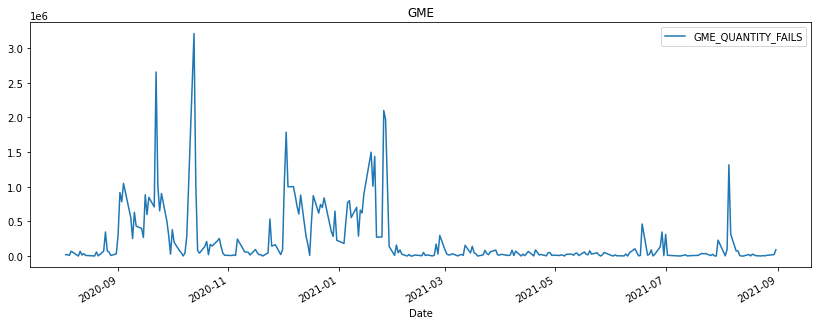

In [13]:
gme_ftd_plot = plot_fails(gme_ftd_df,"GME")

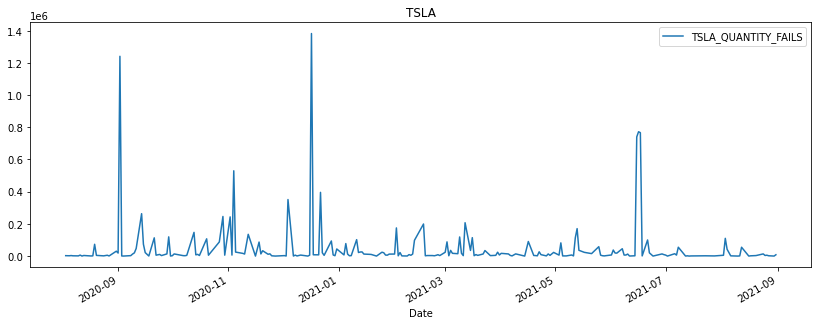

In [14]:
tsla_ftd_plot = plot_fails(tsla_ftd_df,"TSLA")

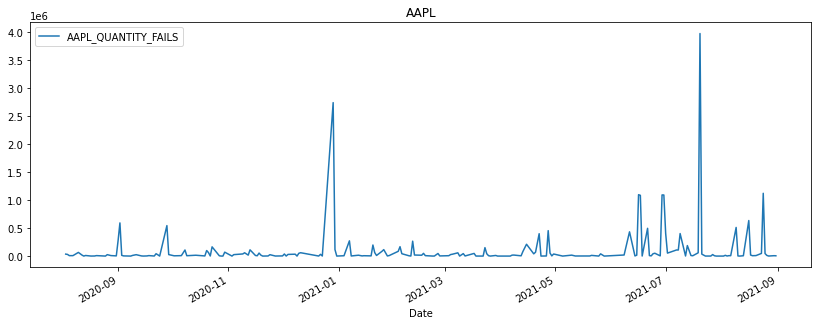

In [15]:
aapl_ftd_plot = plot_fails(aapl_ftd_df,"AAPL")

In [16]:
# def export_csv_data(data,file_title):    
#     data.to_csv('FilesExport/'+file_title+'_ftd_data.csv')
    
# export_csv_data(gme_ftd_df,'GME')